# Loco learning MNIST

A simple example on how to train MNIST digits, step by step



In [1]:
# first, lets load the basics
from IPython.display import display, Image
import pandas as pd
import tensorflow as tf
import numpy as np
import requests
import sys
import os.path


Now lets get the MNIST dataset. 

There are a number of formats out there, and typically you should read the images directly and convert them into a matrix, but in order to save time and be focus on the problem we will download a CSV version directly.

The format is the following.

Each image is 28x28 pixels, those are reshaped into a single dimensions of 28*28 = 784 values. Also we need to know which digits corresponds to each image, so before those 784 values we add a number (from 0 to 9) that tells use which one is the digit on the image. That gives us 784 + 1 = 785 columns, where the first element is the digit itself.

We will define a simple ```download_file``` function to do the downloading for us.

In [2]:
def download_file(link, file_name):
    # Credit goes to ==> https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads
    if os.path.isfile(file_name):
        print("File was already there")
    else:
        with open(file_name, "wb") as f:
            print ("Downloading %s" % file_name)
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')

            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()
    return file_name

Now, lets get the train data and the test data

In [3]:
mnist_filename = "train.csv"
download_file("https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv", mnist_filename)

[===========================================================================================================================================================================================================================================================================================================================================================================================================================]

'train.csv'

It is important now to understand the format of the files

From http://makeyourownneuralnetwork.blogspot.com.au/2015/03/the-mnist-dataset-of-handwitten-digits.html


The first value is the "label", that is, the actual digit that the handwriting is supposed to represent, such as a "7" or a "9". It is the answer to which the neural network is aspiring to classify.

The subsequent values, all comma separated, are the pixel values of the handwritten digit. The size of the pixel array is 28 by 28, so there are 784 values after the label.

So the first thing we need to do is separate the actual labels from the data itself, we will call the data X and the labels y, as we have a train and a test set, we will call them X_train, X_test, y_train, y_test







In [4]:
mnist = pd.read_csv(mnist_filename).as_matrix() # We need to call as_matrix so we can use numpy arrays

So the first thing we need to do is separate the actual labels from the data itself, we will call the data X and the labels y, as we have a train and a test set, we will call them X_train, X_test, y_train, y_test

In numpy this is pretty easy, when operating with a matrix (lets call it MATRIX), one has to provide which rows and columns are to be used. One can simply access row 5 and column 20 by doing MATRIX[5, 20]. 

In our case we want the first column and ALL the rows, that is done by effectively selecting all the rows with 
```
:
``` 
so 

```
train[:,0]
```

For the data itself we want ALL the rows and all the columns except the first one, as everything is zero-indexed, we want everything from the column number one, that is done by using

```
1:
```

so

```
train[:, 1:]
```

In [5]:

train_split = int(mnist.shape[0] * 0.8)
train = mnist[0:train_split,]
test = mnist[train_split:,]

y_train = train[:,0]
X_train = train[:,1:]
y_test = test[:, 0]
X_test = test[:,1:]

Now lets make sure that our shapes are correct, the data should be in shape Nx786 where N is the number of rows, in the case of y, the shape should be N, where N again is the number of rows

In [6]:
print("Shape of X_train ", X_train.shape, " y_train ", y_train.shape)
print("Shape of X_test ", X_test.shape, " y_test ", y_test.shape)

Shape of X_train  (33600, 784)  y_train  (33600,)
Shape of X_test  (8400, 784)  y_test  (8400,)


Lets do a simple explorarion of the dataset

In [7]:
X_train[0:1,]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

As you can see, the values seem to range from 0 to 200s, we are going to need to normalize the values, and for that, we will need the minmum and the maximun.

Lets figure out the min and max values

In [8]:
print("Min value is ", np.min(X_train))
print("Max value is ", np.max(X_train))

Min value is  0
Max value is  255


No surprises here, as we are dealing with grayscale images, values range from 0 to 255, but neuronal networks like values around zero due to numerical stability reasons. We are going to convert them using max-min scaling

The formula to use is 

![normalization.svg](attachment:normalization.svg)

In [9]:
max_value = np.max(X_train)
min_value = np.min(X_train)

X_train_normalized = (X_train - min_value) / (max_value - min_value)
X_test_normalized = (X_test - min_value) / (max_value - min_value)

And lets verify some random values to make triple sure everything is fine

In [10]:
X_train_normalized[42,]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Now lets have a look at the ```y``` values

In [11]:
print(y_train[0:10])

[1 0 1 4 0 0 7 3 5 3]


Makes sense, we seem to have different digits from 0 to 9, however we want them to be ```one-hot-encoded``` that is, 
if the value is 2 then we want a vector of 10 elements looking like 
```
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
```

And if the value was say, 8, then the vector would look like

```
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
```


In [12]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

y_train_one_hot = dense_to_one_hot(y_train, 10)
y_test_one_hot = dense_to_one_hot(y_test, 10)

Now lets verify, remember the output for the first 10 elements was
```
array([0, 4, 1, 9, 2, 1, 3, 1, 4, 3])
```

In [13]:
print("New shape for labels (train set) ", y_train_one_hot.shape)
y_train_one_hot[0:10]

New shape for labels (train set)  (33600, 10)


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now lets start playing with the interesting stuff. 

Initially a simple logistic regression is going to be done using tensorflow.

In [15]:
epochs = 10 # How many passes on all the data
batch_size = 256 # We will pass 256 examples each time
total_batches = X_train_normalized.shape[0] // batch_size # How many batches we will use
columns = 784 # Remember, we are dealing with images of 28x28 pixels unrolled as 28*28 = 786
labels = 10 # There are 10 possible labels (as we have 10 digits from 0 to 9)

weights = tf.Variable(tf.truncated_normal(shape=(columns, labels), stddev=0.1))
biases = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

predictions = tf.add(tf.matmul(X, weights), biases)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [16]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print("Accuracy so far ", accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))    

Accuracy so far  0.13378
Accuracy so far  0.817024
Accuracy so far  0.840952
Accuracy so far  0.870863
Accuracy so far  0.878244
Accuracy so far  0.889792
Accuracy so far  0.893304
Accuracy so far  0.89881
Accuracy so far  0.900536
Accuracy so far  0.904732
Accuracy so far  0.90619
Accuracy so far  0.908839
Accuracy so far  0.910476
Accuracy so far  0.912232
Accuracy so far  0.913363
Accuracy so far  0.914881
Accuracy so far  0.915774
Accuracy so far  0.916964
Accuracy so far  0.917827
Accuracy so far  0.918869
Final accuracy on test set
0.919405


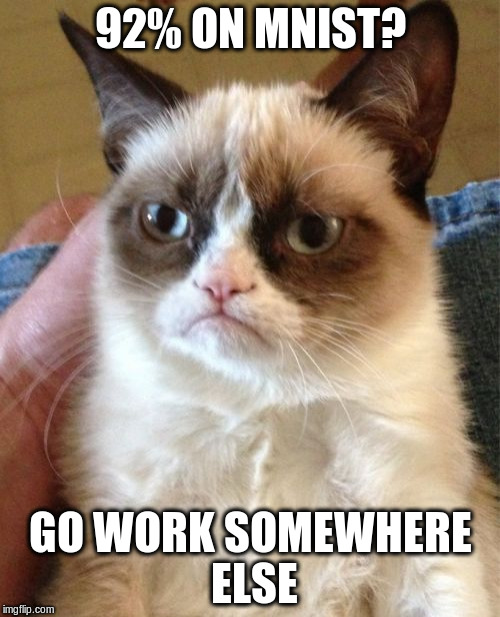

In [17]:
display(Image('grumpy01.jpg', width=400))

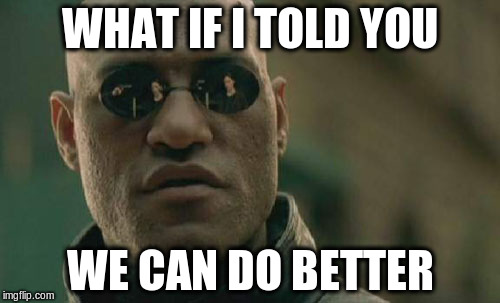

In [18]:
display(Image('morhpeo01.jpeg', width=400))

If instead using logistic regression we use a neuronal network, we will increase the performance substantially.

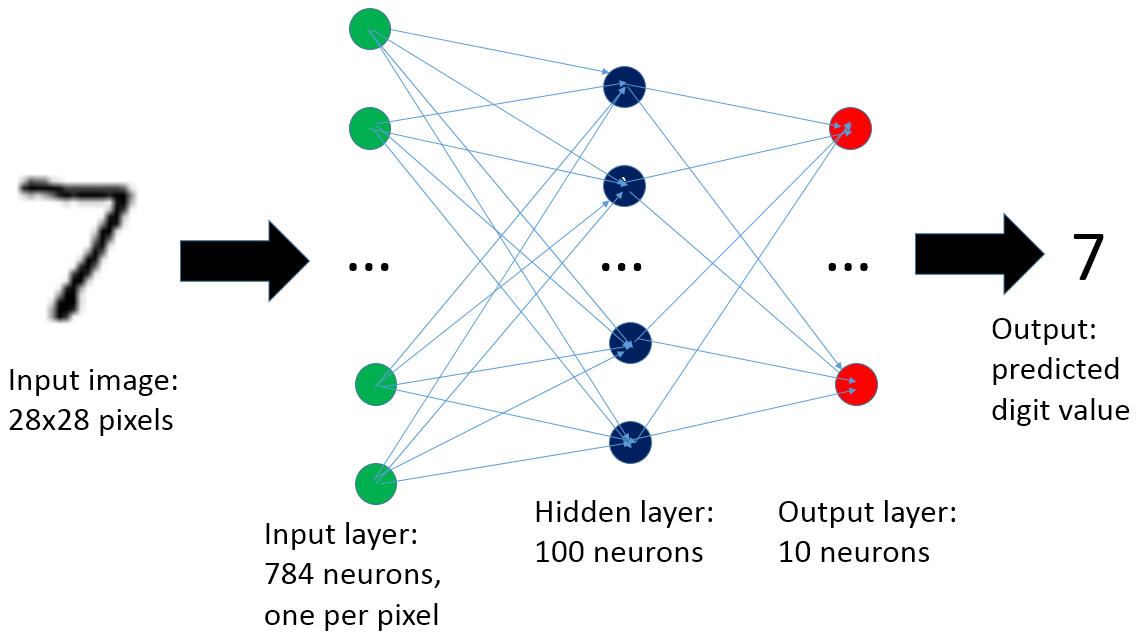

A neuronal network is composed of 1 or more 

In [24]:
hidden_units = 1024

weights = tf.Variable(tf.truncated_normal(shape=(columns, hidden_units), stddev=1/(hidden_units**0.5)))
biases = tf.Variable(tf.zeros(hidden_units))

weights_output = tf.Variable(tf.truncated_normal(shape=(hidden_units, labels), stddev=1/(labels**0.5)))
biases_output = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

hidden_output = tf.add(tf.matmul(X, weights), biases)
hidden_output = tf.nn.relu(hidden_output)
#hidden_output = tf.nn.dropout(hidden_output, 0.7)

predictions = tf.add(tf.matmul(hidden_output, weights_output), biases_output)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))    

0.361458
0.961786
0.969702
0.98006
0.98372
0.988036
0.990357
0.992262
0.991994
0.988542
0.9875
0.991845
0.989435
0.99372
0.995595
0.994583
0.995327
0.996667
0.998214
0.995536
Final accuracy on test set
0.975714


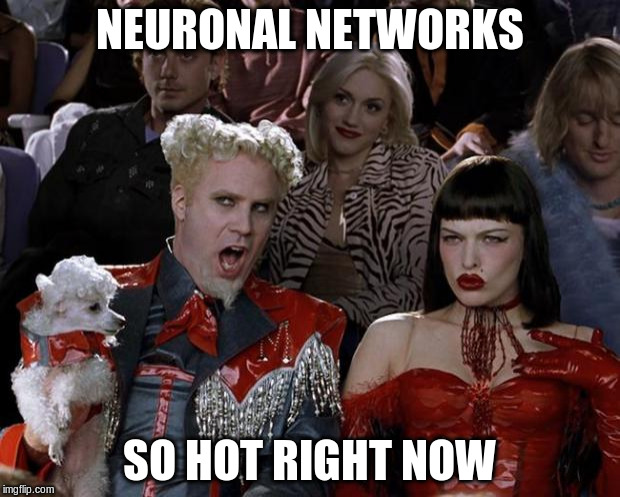

In [51]:
display(Image('zoolander01.jpeg', width=400))

Using a neuronal network gives us a 97.5% accuracy, much better than the initial 92% achieve with logistic regression. 

Can we do better? Sure we can, but before that, lets rewrite the code with a higher level api provided by tensorflow, so we do not have to initialize weights or perform matrix multiplications ourselves.

In [ ]:
hidden_units = 1024

epochs = 20
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output = tf.layers.dense(X, hidden_units, activation = tf.nn.relu)
predictions = tf.layers.dense(hidden_output, labels)  
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=predictions)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for batch_no in range(total_batches):
        start_at = batch_no
        slice_start = start_at*batch_size
        slice_end = slice_start + batch_size
        if slice_start > len(X_train_normalized) or slice_end > len(X_train_normalized):
            start_at = 0
            slice_start = start_at*batch_size
            slice_end = slice_start + batch_size
            print("From ", slice_start, "--", slice_end)

        X_chunk = X_train_normalized[slice_start: slice_end, ]
        y_chunk = y_train_one_hot[slice_start: slice_end, ]

        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 100 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(predictions, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print(accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

0.412113
0.944077
0.951607
0.967232
0.972768
0.979881
0.980923
0.985179
0.985506
0.988929
0.987411
0.989315
0.989286
0.988452
0.993393
0.990952
0.994018
0.992976
0.995327
0.989673
0.996726
0.99381
0.997292
0.998274
0.998452
0.999107
0.998155
0.998958
0.997679
0.999881
0.999583
0.999851
0.999494
0.999911
0.999762
0.99997
0.999911
0.99994
0.99997
0.99997
Final accuracy on test set
